<a href="https://colab.research.google.com/github/Amarmurun0212/Diver/blob/main/finNatural_language_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

--2023-05-29 19:26:33--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.7MB/s    in 4.9s    

2023-05-29 19:26:38 (16.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an a

In [2]:
from sklearn.datasets import load_files
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from  sklearn.metrics  import accuracy_score
from sklearn import metrics
import numpy as np
import re
from collections import Counter
import scipy.sparse as sp
from numpy.linalg import norm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

In [3]:
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target

test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target



# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [4]:
print("x : {}".format(x_train[0]))
print("y : {}".format(y_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.
y : 1


In [5]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]
  
# 1-grim
vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df1 = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names_out())

# 2-grim
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df2 = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names_out())

print("1-gram")
display(df1)
print("2-grim")
display(df2)

1-gram


,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


2-grim


,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


[Question 2] TF-IDF Calculation

In [6]:
# Stop words
stop_words = nltk.download('stopwords')
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words))

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
vectorizer = CountVectorizer(stop_words=stop_words, max_features = 5000)
bow_train = (vectorizer.fit_transform(x_train)).toarray()
bow_test = (vectorizer.fit_transform(x_test)).toarray()
#print(bow_train)
df_train = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names_out())
df_test = pd.DataFrame(bow_test, columns=vectorizer.get_feature_names_out())
display(df_train.head(20))
display(df_test.head(20))
print("df train shape: {}".format(df_train.shape))
print("df test shape: {}".format(df_test.shape))

,00,000,10,100,11,12,13,13th,14,15,...,york,young,younger,youth,zellweger,zero,zoey,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,00,000,10,100,11,12,13,13th,14,15,...,york,young,younger,youth,zellweger,zero,zoey,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df train shape: (25000, 5000)
df test shape: (25000, 5000)


TF-IDF Vectorizer

In [8]:
vectorizer = TfidfVectorizer(norm='l2',max_features = 5000,stop_words=stop_words)
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
#print("Feature names: {}".format(vectorizer.get_feature_names_out()))
print("train shape: {}".format(X_train.shape))
print("tets shape: {}".format(X_test.shape))
print(X_train)

train shape: (25000, 5000)
tets shape: (25000, 5000)
  (0, 2158)	0.16743479423204646
  (0, 4444)	0.10041129167597976
  (0, 2156)	0.1279936881849026
  (0, 1769)	0.15681106322388316
  (0, 3884)	0.05436294092381458
  (0, 2609)	0.13078643200728501
  (0, 267)	0.08381220735492088
  (0, 201)	0.08282260831175318
  (0, 1670)	0.16768439105128702
  (0, 4045)	0.1495900878396859
  (0, 1920)	0.08322948062718752
  (0, 1734)	0.0809511532827876
  (0, 1459)	0.17300582102971174
  (0, 475)	0.13734353234274008
  (0, 111)	0.14007222716965326
  (0, 2932)	0.1671726902261627
  (0, 1606)	0.1649274006108069
  (0, 4443)	0.2625874845921025
  (0, 3436)	0.1465074496779634
  (0, 3635)	0.14016268714570973
  (0, 114)	0.07492419060647448
  (0, 1737)	0.14034457344060158
  (0, 4515)	0.052427901534780254
  (0, 2907)	0.0905258969962952
  (0, 1933)	0.09528142995538946
  :	:
  (24999, 3233)	0.03561752132456323
  (24999, 902)	0.1001893037306074
  (24999, 2053)	0.06323310163928071
  (24999, 1739)	0.08018138417806203
  (24999, 2

[Question 3] Learning with TF-IDF

In [9]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear', random_state=0, verbose=True) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

[LibSVM]

SVC(kernel='linear', random_state=0, verbose=True)

[Question 4] TF-IDF scratch mounting

In [10]:
class TFIDF(object):

    def __init__(self, corpus):        
        self.corpus = corpus      

    def __normalize_corpus(self, d):
        stop_words = nltk.corpus.stopwords.words('english')
        d = re.sub(r'[^a-zA-Z0-9\s]', '', d, re.I|re.A)
        d = d.lower().strip()
        tks = nltk.word_tokenize(d)
        f_tks = [t for t in tks if t not in stop_words]
        return ' '.join(f_tks)

    def preprocessing_text(self):
        n_c = np.vectorize(self.__normalize_corpus)
        self.norm_corpus = n_c(self.corpus)

    def tf(self):
        words_array = [doc.split() for doc in self.norm_corpus]
        words = list(set([word for words in words_array for word in words]))
        features_dict = {w:0 for w in words}
        tf = []
        for doc in self.norm_corpus:
            bowf_doc = Counter(doc.split())
            all_f = Counter(features_dict)
            bowf_doc.update(all_f)
            tf.append(bowf_doc)
        return pd.DataFrame(tf)

    def df(self, tf):
        features_names = list(tf.columns)
        df = np.diff(sp.csc_matrix(tf, copy=True).indptr)
        df = 1 + df
        return df
        
    def idf(self, df):
        N = 1 + len(self.norm_corpus)
        idf = (1.0 + np.log(float(N) / df)) 
        idf_d = sp.spdiags(idf, diags= 0, m=len(df), n= len(df)).todense()      
        return idf, idf_d

    def tfidf(self, tf, idf):        
        tf = np.array(tf, dtype='float64')
        tfidf = tf * idf
        norms = norm(tfidf , axis=1)
        return (tfidf / norms[:,None])

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
mini_dataset2 = \
    ["This movie is SOOOO funny!!!",
    "What a movie! I never",
    "best movie ever!!!!! this movie"]
    
    
tfidf_scratch = TFIDF(mini_dataset2)
tfidf_scratch.preprocessing_text()

tf = tfidf_scratch.tf()
print("TF:\n",tf)

df = tfidf_scratch.df(tf)
print("df\n",df)

idf, idf_2 = tfidf_scratch.idf(df)
print("IDF:\n",idf)

tfidf = tfidf_scratch.tfidf(tf,idf)
print("TF-IDF: \n",tfidf)

df = pd.DataFrame(np.round(tfidf,2),columns = list(tf.columns))
display(df)

TF:
    movie  soooo  funny  ever  best  never
0      1      1      1     0     0      0
1      1      0      0     0     0      1
2      2      0      0     1     1      0
df
 [4 2 2 2 2 2]
IDF:
 [1.         1.69314718 1.69314718 1.69314718 1.69314718 1.69314718]
TF-IDF: 
 [[0.38537163 0.65249088 0.65249088 0.         0.         0.        ]
 [0.50854232 0.         0.         0.         0.         0.861037  ]
 [0.64105545 0.         0.         0.54270061 0.54270061 0.        ]]


,movie,soooo,funny,ever,best,never
0,0.39,0.65,0.65,0.00,0.00,0.00
1,0.51,0.00,0.00,0.00,0.00,0.86
2,0.64,0.00,0.00,0.54,0.54,0.00


【Problem 5】Corpus pretreatment

In [13]:
vectorizer = CountVectorizer(stop_words=stop_words, max_features = 5000)
bow_train = (vectorizer.fit_transform(x_train)).toarray()
sentences = vectorizer.get_feature_names_out()
print(sentences)

['00' '000' '10' ... 'zombie' 'zombies' 'zone']


[Question 6] Learning Word2Vec

In [14]:
model = Word2Vec(min_count=1, vector_size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs) # 学習

print("Vocabulary list : {}".format(model.wv.key_to_index.keys()))

for vocab in model.wv.key_to_index.keys():
  print("{} vector of : \n{}".format(vocab, model.wv[vocab]))

Vocabulary list : dict_keys(['e', 'i', 'a', 's', 'r', 'n', 't', 'o', 'l', 'd', 'c', 'u', 'p', 'g', 'm', 'h', 'y', 'b', 'f', 'v', 'w', 'k', 'x', 'j', '0', '1', 'z', 'q', '9', '3', '2', '7', '8', '5', '6', '4', 'é'])
e vector of : 
[-0.31388378 -0.08519313 -0.18837893  0.02742581  0.31337282 -0.27421963
  0.68425304 -0.2950144  -0.5465022  -0.40188572]
i vector of : 
[-0.1969623  -0.09548744 -0.27339092 -0.01109043  0.33247694 -0.2220017
  0.62438923 -0.321403   -0.54910773 -0.44461915]
a vector of : 
[-0.20613572 -0.06136078 -0.15727212 -0.0891547   0.45796248 -0.23210815
  0.6009311  -0.3566686  -0.55771923 -0.40778375]
s vector of : 
[-0.37588558 -0.15011518 -0.1369598  -0.17328347  0.3555564  -0.15745324
  0.61172396 -0.4415396  -0.43335158 -0.29368633]
r vector of : 
[-0.4390526  -0.11956877 -0.38856256 -0.18180239  0.446547   -0.12984617
  0.5415695  -0.3543187  -0.47181728 -0.15323792]
n vector of : 
[-0.4172554  -0.11936913 -0.268346   -0.03874923  0.44024816 -0.17489338
  0.5459

[Question 7] (Advanced Task) Visualization of vectors

In [15]:
model.wv.most_similar(positive="a", topn=3)

[('o', 0.9875813722610474),
 ('k', 0.9847515225410461),
 ('i', 0.9846354126930237)]

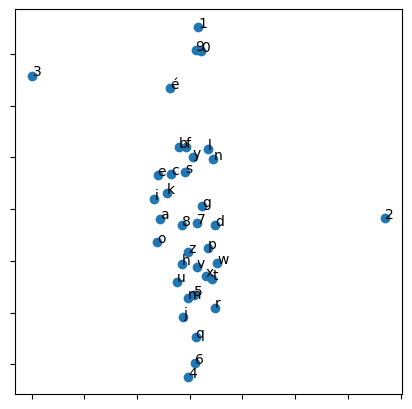

In [16]:
vocabs = model.wv.key_to_index.keys()

tsne_model = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model.wv[vocabs])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()